In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import _linear
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle

from plot_module import text_plot
from plot_module import structure_vocabulary_plots
from plot_module import ComparePlots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL

In [2]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'w')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'r')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)   

number of not one byte characters:  0
min order index:  9
max order index:  255
total number of characters:  196


In [3]:
#different
offset = 20000
valid_size = 10000
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99350000 n in the February 1934 riots, anarchists divided over a 'united 
10000 ture in Mutual Aid: A Factor of Evolution (1897). Subsequent ana


In [4]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)


string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print("Vocabulary: ", string_vocabulary)
print("char2id(u'a') = %s,  char2id(u'z') = %s,  char2id(u' ') = %s" % (char2id(u'a', characters_positions_in_vocabulary),
                                                                        char2id(u'z', characters_positions_in_vocabulary),
                                                                        char2id(u' ', characters_positions_in_vocabulary)))
print("id2char(78) = %s,  id2char(156) = %s,  id2char(140) = %s" % (id2char(78,
                                                                            vocabulary),
                                                                    id2char(156,
                                                                            vocabulary),
                                                                    id2char(140,
                                                                            vocabulary)))


Vocabulary:  	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ
char2id(u'a') = 67,  char2id(u'z') = 92,  char2id(u' ') = 2
id2char(78) = l,  id2char(156) = Ø,  id2char(140) = È


In [5]:
batch_size_test=64
num_unrollings_test=10

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)

print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))

[u'n in the Fe', u".\n* ''[[Con", u"oldier's so", u'\xf6hm-Bawerk ', u'tification,', u' warrior, a', u'uot; would ', u' 115       ', u'orbata acid', u'>\n      <co', u'ate, the co', u'other natio', u'ing the his', u'et bromine;', u' Christ&quo', u' average]] ', u' their home', u'ks and a ri', u'on]]/[[Joel', u' new era fo', u'aph that th', u' known as t', u's from the ', u'ast majorit', u'trips, thou', u'ent of regi', u'metric aspe', u'd named by ', u'Z</timestam', u'tude of 1 c', u'!&quot; [ht', u'o ==\n\n* [[D', u'[[Belarusia', u'iton]], Rus', u'ccessful si', u'es his theo', u' explain th', u' the South.', u'sing with a', u'd ball is h', u'e could des', u'[Friedrich ', u'th virtuall', u' foreign ac', u'variant in ', u'd and watch', u"t; ''[[Foot", u' became Lea', u'stern Europ', u' </contribu', u'ese terms n', u'arting in t', u'gence of th', u'of the cons', u'uickly swit', u', thus star', u'lly develop', u'g the offic', u'esult, the ', u'red HMMWV. ', u'ament is de', u'University ', 

In [6]:

class stretching_memory_hint(MODEL):
    def swap_layer(self, 
                   inp_t,
                   state_t_minus_1,
                   memory_t_minus_1):
        X_t = tf.concat(1, [inp_t,
                            state_t_minus_1,
                            memory_t_minus_1])
        RES = tf.matmul(X_t, self.Matrix) + self.Bias
        state_t = tf.tanh(RES)
        return state_t
    
    def layer(self,
              inp_t,
              state_t_minus_1):
        X_t = tf.concat(1, [inp_t,
                            state_t_minus_1])
        RES = tf.matmul(X_t, self.Base_Matrix) + self.Base_Bias
        state_t = tf.tanh(RES)
        return state_t  
    
    def modify_frequency(self, controller):
        frequency_update = controller['current_frequency'].assign(tf.constant(2, dtype=tf.int32))
        return frequency_update
    
    def dont_modify_frequency(self, controller):
        return self.pointless1
    
    def modify_swap_frequency(self, controller):
        counter_update = controller['swap_counter'].assign(tf.constant(0, dtype=tf.int32))
        frequency_update = tf.assign_add(controller['current_frequency'], tf.constant(1, dtype=tf.int32))
        with tf.control_dependencies([frequency_update]):
            frequency_update = tf.cond(tf.equal(controller['current_frequency'], tf.constant(self._swap_limit+1)),
                                       lambda: self.modify_frequency(controller),
                                       lambda: self.dont_modify_frequency(controller))
        return [counter_update, frequency_update]
    
    def dont_modify_swap_frequency(self, controller):
        return [self.pointless1, self.pointless1]
    
    def perform_swap(self, new_memory, controller):
        necessary_operations = list()
        swap_update = controller['letters_counter_after_swap'].assign(tf.constant(0, dtype=tf.int32))
        counter_update = tf.assign_add(controller['swap_counter'], tf.constant(1, dtype=tf.int32))
        with tf.control_dependencies([counter_update]):
            [counter_update, frequency_update] = tf.cond(tf.equal(controller['swap_counter'], tf.constant(self._lesson_duration, dtype=tf.int32)),
                                                         lambda: self.modify_swap_frequency(controller),
                                                         lambda: self.dont_modify_swap_frequency(controller))
        necessary_operations.append(swap_update)
        necessary_operations.append(counter_update)
        necessary_operations.append(frequency_update)
        necessary = tf.group(*necessary_operations)
        return [new_memory, necessary]
       
    
    def iteration(self, inp, state):
        output = self.layer(inp,
                            state[0])
        return output, [output, output]
    
    def swap_iteration(self, inp, state, controller):
        swap_update = tf.assign_add(controller['letters_counter_after_swap'], tf.constant(1, dtype=tf.int32))
        with tf.control_dependencies([swap_update]):
            swap = tf.less_equal(controller['current_frequency'], controller['letters_counter_after_swap'])
        
        [memory, necessary] = tf.cond(swap,
                                      lambda: self.perform_swap(state[0], controller),
                                      lambda: [state[1], self.pointless3])
        with tf.control_dependencies([necessary]):
            output = self.swap_layer(inp,
                                     state[0],
                                     memory)
        return output, [output, memory], swap, [swap_update, necessary]
    
    def reduce_hint_matrix(self):
        return self.Hint_Matrix.assign(tf.constant(self._reducer) * self.Hint_Matrix)
    
    def dont_reduce(self):
        return self.Hint_Matrix
    
    def unrollings(self, train_inputs, state):
        outputs = list()
        swaps = tf.constant(False, dtype=tf.bool, shape=[self._num_unrollings]) 
        for inp in train_inputs:
            output, state = self.iteration(inp, state)
            outputs.append(output)  
        return [tf.concat(0, outputs), tf.concat(0, state), swaps]
    
    def swap_unrollings(self, train_inputs, state, controller):
        outputs = list()
        swaps = list()
        reduce_operation = tf.cond(self.disable_hint,
                                             lambda: self.reduce_hint_matrix(),
                                             lambda: self.dont_reduce())
        upgrades = [self.pointless1, self.pointless3]
        with tf.control_dependencies([reduce_operation]):
            for inp in train_inputs:
                with tf.control_dependencies(upgrades):
                    output, state, swap, upgrades = self.swap_iteration(inp, state, controller)
                    outputs.append(output)      
                    swaps.append(swap)
        return [tf.concat(0, outputs), tf.concat(0, state), tf.pack(swaps)]  
    
    def optimizer_with_hint(self):
        gradients, v = zip(*self.Optimizer.compute_gradients(self._loss,
                                                             var_list=self.all_trainable))
        gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
        """optimizer"""
        optimizer_apply = self.Optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)  
        return optimizer_apply
    
    def optimizer_without_hint(self):
        gradients, v = zip(*self.Optimizer.compute_gradients(self._loss,
                                                             var_list=self.all_trainable[:-1]))
        gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
        """optimizer"""
        optimizer_apply = self.Optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)  
        return optimizer_apply
    
    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_layers,
                 num_nodes,
                 lesson_duration,
                 swap_limit,
                 disable,
                 reducer,
                 train_text,
                 valid_text):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        self._num_unrollings = num_unrollings
        self._num_layers = num_layers
        self._num_nodes = num_nodes
        self._lesson_duration = lesson_duration
        self._swap_limit = swap_limit
        self._disable = list(disable)
        self._reducer = reducer
        self._train_text = train_text
        self._valid_text = valid_text
        self._valid_size = len(valid_text)
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "half_life": 4,
                         "decay": 5,
                         "num_steps": 6,
                         "averaging_number": 7,
                         "lesson_duration": 8,
                         "swap_limit": 9,
                         "disable": 10,
                         "reducer": 11,
                         "type": 12}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            with self._graph.device('/gpu:0'): 
                self.Base_Matrix = tf.Variable(
                    tf.truncated_normal([self._vocabulary_size + self._num_nodes[0], self._num_nodes[0]],
                                        stddev=0.1))
                self.Base_Bias = tf.Variable(tf.zeros([self._num_nodes[0]]))
                self.Hint_Matrix = tf.Variable(
                    tf.truncated_normal([self._num_nodes[0], self._num_nodes[0]],
                                        stddev=0.1))

                self.Matrix = tf.concat(0, [self.Base_Matrix, self.Hint_Matrix])
                self.Bias = self.Base_Bias
                # classifier 
                weights = tf.Variable(tf.truncated_normal([self._num_nodes[-1], self._vocabulary_size], stddev = 0.1))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.

                saved_state = [tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False),
                               tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False)]
                
                """global step"""
                self._global_step = tf.Variable(0, trainable=False)
                
                """swap regime"""
                self.swap_regime = tf.less(self._global_step, tf.constant(self._disable[1])) 
                self.disable_hint = tf.logical_and(self.swap_regime, tf.greater_equal(self._global_step, tf.constant(self._disable[0])))
                
                outputs = list()
                state = saved_state

                self.controller = dict()
                self.controller['letters_counter_after_swap'] = tf.Variable(0, trainable=True)
                self.controller['swap_counter'] = tf.Variable(0, trainable=False)
                self.controller['current_frequency'] = tf.Variable(2, trainable=False)
                
                pointless_variable = tf.Variable(0)
                self.pointless1 = pointless_variable.assign(tf.constant(0))
                self.pointless3 = tf.group(*[pointless_variable.assign(tf.constant(0)),
                                             pointless_variable.assign(tf.constant(0)),
                                             pointless_variable.assign(tf.constant(0))])
                self.pointless4 = tf.group(*[pointless_variable.assign(tf.constant(0)),
                                             pointless_variable.assign(tf.constant(0)),
                                             pointless_variable.assign(tf.constant(0)),
                                             pointless_variable.assign(tf.constant(0))])

                """swap print"""
                [outputs, state, self.swaps] = tf.cond(self.swap_regime,
                                                       lambda: self.swap_unrollings(train_inputs, state, self.controller),
                                                       lambda: self.unrollings(train_inputs, state))
                state = tf.split(0, 2, state)

                save_list = list()
                
                save_list.append(saved_state[0].assign(state[0]))
                save_list.append(saved_state[1].assign(state[1]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)
                
                with tf.control_dependencies(save_list):
                        # Classifier.
                    logits = tf.nn.xw_plus_b(outputs, weights, bias)
                    """loss"""
                    self._loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                        logits, tf.concat(0, train_labels)))
                # Optimizer.
                
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(0.5,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                self.all_trainable = [self.Base_Matrix, self.Base_Bias, weights, bias, self.Hint_Matrix]
                """Optimizer"""
                self.Optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)

                """optimizer"""
                self._optimizer = tf.cond(tf.logical_and(self.swap_regime,
                                                         tf.logical_not(self.disable_hint)),
                                          self.optimizer_with_hint,
                                          self.optimizer_without_hint)  
                """train prediction"""
                self._train_prediction = tf.nn.softmax(logits)

                # Sampling and validation eval: batch 1, no unrolling.
                saved_sample_state = list()
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])

                sample_controller = dict()
                sample_controller['letters_counter_after_swap'] = tf.Variable(0, trainable=True)
                sample_controller['swap_counter'] = tf.Variable(0, trainable=False)
                sample_controller['current_frequency'] = tf.Variable(2, trainable=False)

                reset_list = list()
                reset_list.append(saved_sample_state[0].assign(tf.zeros([1, self._num_nodes[0]])))
                reset_list.append(saved_sample_state[1].assign(tf.zeros([1, self._num_nodes[0]])))
                reset_list.append(sample_controller['letters_counter_after_swap'].assign(tf.constant(0, dtype=tf.int32)))
                reset_list.append(sample_controller['swap_counter'].assign(tf.constant(0, dtype=tf.int32)))
                reset_list.append(sample_controller['current_frequency'].assign(tf.constant(2, dtype=tf.int32)))
                """reset sample state"""
                self._reset_sample_state = tf.group(*reset_list)

                [sample_outputs, sample_state, _] = tf.cond(self.swap_regime,
                                                          lambda: self.swap_unrollings([self._sample_input], saved_sample_state, sample_controller),
                                                          lambda: self.unrollings([self._sample_input], saved_sample_state))                
                sample_state = tf.split(0, 2, sample_state)
                sample_output = sample_outputs
                sample_save_list = list()
                sample_save_list.append(saved_sample_state[0].assign(sample_state[0]))
                sample_save_list.append(saved_sample_state[1].assign(sample_state[1]))

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, weights, bias)) 
                
                
                """saver"""
                self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)
        metadata.append(self._num_layers)
        metadata.append(list(self._num_nodes))
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append(self._lesson_duration)
        metadata.append(self._swap_limit)
        metadata.append(list(self._disable))
        metadata.append(self._reducer)
        metadata.append('stretching_memory_hint')
        return metadata
  

In [11]:

model = stretching_memory_hint(64,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 30,
                 1,
                 [128],
                               2000,
                 2,
                           [79000, 79500],
                           0.997,
                 train_text,
                 valid_text)

In [8]:
fuse_texts = [u'my name is', u'december elegy', u'they have done']
model.run(30,
          0.9,
            2000,
            40,
            3,
            1,
            20,
          print_intermediate_results = True,
          fuse_texts=fuse_texts)

Initialized
Average loss at step 0: 5.397593 learning rate: 0.500000
Percentage_of correct: 0.00%

random:
ó*	á×÷Ç®¦PU{;öînªlï*&ñN{E;TMwYg³ÛG9L³;°ßóÙH>ÞÖæ7ÏÅìáX=µÅp·æî=ÂÂ5ï\h&1PÚa=RB_#
i°y¶Qª#b?ÏmE"¼&zºíCî?°z62Åm¤ùE«ïQ×7Õá.Z¯t]¯;âAÿñ¡Wäæ¢~Ë4JëÑ©tSfk°^¢>&vA ×Bu]6ìâf
f·y®Q¸SSÓÎ|ðÖj¯¨¯~ÙÅø°¿^BûcÙ,ÐÖnG]q"ë<
~þ^Ûg¹H¬áÆ-BíeüN`áès.1 æ|_ÏðX×ÅýÄk;ÂÊÙÜ
ß°K¡ZÔ!päÚÔjqälF9rlúö`Þµ8Ha¬Ì¢tÙ÷§fjH)ÉÄKÍ]æ¯^pX _À E¯3õÕåzÀÆZ[ÎÖnu4 l1Yp\íí
K
é¿6_js³{÷TgcrMl!;_¸n¼d
e5tÁ×¡è;¬+{LgÂ ¹Y¸CýËW.|Ø¼ÆE¸°õ_¼gp_Àg¶2¼ÃÛ«äà§dnáÄÂf>

from fuse:
0. fuse: my name is
my name isV}ípÝÛ++w|B`ÙÓÜ£W³¾±åEâÀavßME´ýïù¬Áv.7ßy2¬ ïÑÐ(gäE¸Ô§%%1KCW<ùUëÜÖFFÔ¦Q´ÞuTÊcoÄ
1. fuse: december elegy
december elegyÿþ £`cE­\¿6¹7ËGñ-ö¬ú$Rë79û±©;·½xÌhÂf?J±MW×
´%Å02?®ÞLR>*¢¢²Ø*!ýA?WµØÔù~-Ný©èæm
2. fuse: they have done
they have donet4â×r¢AEPä¤@IìF §Çï9þuVDµýËSHþÕt%Þ+!ø@¼²Ìó)ïØw Al«§ôíºçO¨~¤Ùè4wÔÙ#)ªzü¶ú8WYYoÙë
Validation percentage of correct: 1.00%

Average loss at step 2000: 2.732262 learning rate: 0.500000
Percentage_of correct: 29.20%

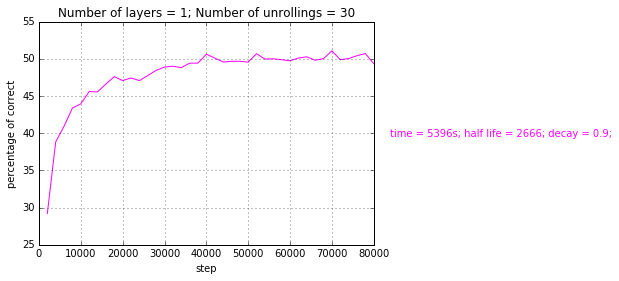

In [9]:
model.plot([0], save=True, save_folder='stretching_memory_hint')

In [8]:
swap_limit_values = [3, 4, 5, 6, 7, 10, 15, 20]
lesson_duration_values = [2000, 100, 10]
results_GL = list()
for swap_limit_value in swap_limit_values:
    print("\n", ' '*5, "swap limit: ", swap_limit_value)
    for lesson_duration_value in lesson_duration_values:
        print("\nlesson duration: ", lesson_duration_value)
        model = stretching_memory_hint(64,
                         vocabulary,
                         characters_positions_in_vocabulary,
                         30,
                         1,
                         [128],
                                       lesson_duration_value,
                             swap_limit_value,
                           [79000, 79500],
                           0.98,                             
                         train_text,
                         valid_text)
        model.simple_run(200,
                       'stretching_memory_hint/nn128/variables/ld%s_swl%s' % (lesson_duration_value, swap_limit_value),
                       80000,
                       4000,
                       5000,        #learning has a chance to be stopped after every block of steps
                       30,
                       0.9,
                       3)
        results_GL.extend(model._results)
        model.destroy()
        del model
        gc.collect()


       swap limit:  3

lesson duration:  2000
Number of steps = 80001     Percentage = 49.16%     Time = 3890s     Learning rate = 0.0212

lesson duration:  100
Number of steps = 80001     Percentage = 49.30%     Time = 3889s     Learning rate = 0.0212

lesson duration:  10
Number of steps = 80001     Percentage = 49.33%     Time = 3856s     Learning rate = 0.0212

       swap limit:  4

lesson duration:  2000
Number of steps = 80001     Percentage = 49.52%     Time = 3855s     Learning rate = 0.0212

lesson duration:  100
Number of steps = 80001     Percentage = 49.64%     Time = 3826s     Learning rate = 0.0212

lesson duration:  10
Number of steps = 80001     Percentage = 49.55%     Time = 3934s     Learning rate = 0.0212

       swap limit:  5

lesson duration:  2000
Number of steps = 80001     Percentage = 49.80%     Time = 3895s     Learning rate = 0.0212

lesson duration:  100
Number of steps = 80001     Percentage = 49.49%     Time = 3863s     Learning rate = 0.0212

lesson du

In [9]:
folder_name = 'stretching_memory_hint'
file_name = 'stretching_memory_hint_ns_80000_hl_2667_dc_0.9_nu_30_ld5-2000_sl3-20.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling stretching_memory_hint/stretching_memory_hint_ns_80000_hl_2667_dc_0.9_nu_30_ld5-2000_sl3-20.pickle.


In [12]:
from plot_module import ComparePlots

stretching_memory_hint_plots = ComparePlots('stretching_memory_hint')
stretching_memory_hint_plots.add_network(results_GL, model._indices)



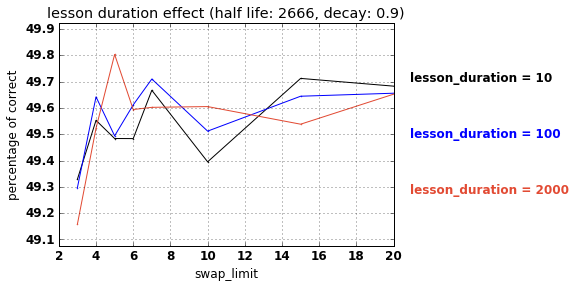

In [16]:

plot_data, _ = stretching_memory_hint_plots.one_key_layout_data('stretching_memory_hint_1',
                                                                'swap_limit',
                                         "lesson_duration")
stretching_memory_hint_plots.save_layout(plot_data[0],
                    'lesson duration effect (half life: 2666, decay: 0.9)',
                    ['lesson_duration_effect', 'plots'],
                    'nn128;ns80000;hl2666;dc0.9')
stretching_memory_hint_plots.draw(plot_data[0], 'lesson duration effect (half life: 2666, decay: 0.9)')